# Desafío 2 - Procesamiento del Lenguaje Natural I
### Carrera de Especialización en Inteligencia Artificial - Cohorte 17
##### Docentes: Rodrigo Cárdenas / Nicolás  Vattuone
#### Autor: Alejandro Lloveras

***NOTA PARA EJECUCIÓN:***
- Cada punto de la resolución debe ejecutarse de forma unitaria: se inicializa ejecutando la sección 'Indotrucción' y luego la sección del punto correspondiente.

### Consigna

1. Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
2. Probar términos de interés y explicar similitudes en el espacio de embeddings.
3. Intentar plantear y probar tests de analogías. Graficar los embeddings resultantes.
4. Sacar conclusiones.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pickle

## Importación del dataset
Para este desafío trabajaré con un dataset de cosecha propia, compuesto por +3700 letras de tango.

Para su construcción realicé scraping del sitio *todotango.com*
> https://www.todotango.com/musica/obras/letras/-/7/Tango/

### Descripción del dataset

- Compuesto por **3.769 elementos** *(canciones)*
- Idioma Español -> Variante Rioplatense -> Argot lunfardo
- Cada letra se encuentra almacenada en un archivo .TXT dentro de la carpeta 'lyrics' *(cod. utf-8)*
- Almacenamiento 15,4 MB

## Importación de archivos

In [6]:
# Posibles bandas
# os.listdir("./songs_dataset/")
ROOT = "./lyrics/"
files = [file for file in os.listdir(ROOT) if file.endswith('.txt')]
files

['92_A río revuelto.txt',
 '558_Balas de salva.txt',
 '2667_La crisis.txt',
 '3587_Muchacho.txt',
 '3970_Pamperito.txt',
 '2059_Era de mañana.txt',
 '4618_Se cortó la redoblona.txt',
 '2091_Escolaso.txt',
 '314_Amor de a tres.txt',
 '3563_Monte criollo.txt',
 '5428_Vía crucis.txt',
 '4424_Quién tiene tu amor.txt',
 '3899_Oscarcito.txt',
 '2288_Garabita.txt',
 '4771_Sin lágrimas.txt',
 '3895_Oro y seda.txt',
 '1670_El borracho [b].txt',
 '2302_Gaucha.txt',
 '4508_Ríe payaso.txt',
 '3435_Mientras llora el tango.txt',
 '4999_Tapera.txt',
 '3432_Midinette porteña.txt',
 '281_Alta clase.txt',
 '247_Allá en la ribera.txt',
 '5269_Un día cualquiera.txt',
 '1982_En el dos mil.txt',
 '5165_Trenzas.txt',
 '2040_Ensueños.txt',
 '5072_Tiempo de nadie.txt',
 '4529_Ronda de ases.txt',
 '949_Carpeta.txt',
 '5094_Tirate un lance.txt',
 '1176_Con las manos vacías.txt',
 '702_Buenos Aires fénix.txt',
 '1420_Decime cómo está.txt',
 '201_Al fin de cuentas.txt',
 '2089_Esclavas blancas.txt',
 '2518_Intimas

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
corpus = pd.DataFrame(columns=[''])
total_work = len(files)
for count, file in enumerate(files):
    try:
        if count % 10 == 0 and count > 0:
            print(f"💡 Progreso: {count/total_work*100:.2f}%\n")
        new_song = pd.read_csv(f'{ROOT}{file}', header=None, sep='/n', engine='python')
        title = new_song.values[0][0]
        if count % 2 == 0:
            print(count, title[:50],sep=": ")
        corpus = pd.concat([corpus, new_song], ignore_index=True)
    except FileNotFoundError:
        print(f"Error: File '{ROOT}{file}' not found.\n")
    except pd.errors.ParserError:
        print(f"Error: Could not parse file '{ROOT}{file}'.\n")
print("✅ Importación finalizada exitosamente.\nSe cargaron un total de {count} canciones.")

0: A río revuelto se mueren los peces
1: Mis manos como lluvia,
2: El lompa gastado, los tarros torcidos,
3: Muchacho que porque la suerte quiso
4: Soy el criollo apasionado
5: Era de mañana, vos por el sendero
6: En tu vida de milonga,
7: En descartes pensativos
8: Este amor prohibido, este amor secreto
9: Cuarenta cartones pintados
💡 Progreso: 0.27%

10: Yo nací casi igual que Jesús
11: He recibido una cartita tuya
12: Con permiso compañero,
13: Garabita... Garabita...
14: No sabes cuánto te he querido,
15: (Recitado)
16: Yo soy un borracho y a nadie le importa
17: Gaucha fiel, mi corazón
18: El payaso con sus muecas
19: Mientras el taita compadrón
💡 Progreso: 0.53%

20: Al fin, un rancho más que se deja,
21: "Midinette" que trabajas todo el año,
22: Jarroncito azul de Sevres,
23: Allá en la ribera, la tarde se aleja,
24: Llega la mañana: saltar de la cama, ir a trabajar,
25: Vendrás del viaje loco y sideral,
26: Trenzas,
27: Ensueños... fantasías del ayer...
28: Vení no te vayas, ni

In [ ]:
# Almacena como CSV
corpus.to_csv('corpus.csv', index=False, header='line', encoding='utf-8')

## 1. Vectorización con Gensim

In [ ]:
# Instala packete de preprocesamiento de Español
!python -m spacy download es_core_news_md

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.8.0/es_core_news_md-3.8.0-py3-none-any.whl (42.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [ ]:
import spacy

# Cargar pipeline de preprocesamiento de Español
nlp = spacy.load('es_core_news_md')

def spacy_process(text, verbose = False):
    doc = nlp(text)
    
    # Tokenization & lemmatization
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)

    if verbose:
        print("Tokenize + Lemmatize:")
        print(lemma_list)
    
    # Stop words
    filtered_sentence =[]
    for word in lemma_list:
        # word es un string, para recuperar la información de los objetos de SpaCy
        # necesitamos usar el string para pasar a un lexema, el objeto de SpaCy
        # que para cada término contiene la información del preprocesamiento
        # (se podría también directamente filtrar stopwords en el paso de lematización)
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    
    # Filter punctuation
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    if verbose:
        print(" ")
        print("Remove stopword & punctuation: ")
        print(filtered_sentence)
    return filtered_sentence

In [158]:
# Prueba del tokenizador
text = corpus.values[0][0]
print(text)
tokens = spacy_process(text,verbose=True)

A río revuelto se mueren los peces
Tokenize + Lemmatize:
['a', 'río', 'revuelto', 'él', 'morir', 'el', 'pez']
 
Remove stopword & punctuation: 
['río', 'revuelto', 'morir', 'pez']


In [166]:
sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones (resuelto con spaCy)
total_work = len(corpus)
for count, row in corpus[:None].iterrows():
    sentence_tokens.append(spacy_process(row.iloc[0]))
    print(f"\r💡 Progreso: {count/total_work*100:.2f}%     ",end='')
print("\r✅ Se ha completado exitosamente el proceso de tokenización.",end='')

✅ Se ha completado exitosamente el proceso de tokenización.

In [ ]:
# Guardar sentence_tokens en un archivo pickle
with open('sentence_tokens.pkl', 'wb') as f:
    pickle.dump(sentence_tokens, f)

print("✅ Los tokens se han guardado como 'sentence_tokens.pkl'")

✅ Los tokens se han guardado como 'sentence_tokens.pkl'


#### 2 - Crear los vectores (word2vec)

In [ ]:
# Cargar sentence_tokens desde el archivo pickle
with open('sentence_tokens.pkl', 'rb') as f:
    loaded_tokens = pickle.load(f)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [168]:
from gensim.models import Word2Vec

# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [169]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [170]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 112054


In [171]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 5972


#### 3 - Entrenar embeddings

In [172]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 1622086.375
Loss after epoch 1: 856530.625
Loss after epoch 2: 753008.0
Loss after epoch 3: 747021.25
Loss after epoch 4: 718520.75
Loss after epoch 5: 699222.0
Loss after epoch 6: 687966.5
Loss after epoch 7: 677054.0
Loss after epoch 8: 665268.0
Loss after epoch 9: 654389.0
Loss after epoch 10: 635365.5
Loss after epoch 11: 611585.0
Loss after epoch 12: 602144.0
Loss after epoch 13: 592415.0
Loss after epoch 14: 584552.0
Loss after epoch 15: 576094.0
Loss after epoch 16: 570350.0
Loss after epoch 17: 564352.0
Loss after epoch 18: 560065.0
Loss after epoch 19: 557582.0


(4173595, 5374460)

In [175]:
# Guardar los embeddings en un archivo pickle
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

print("✅ Los embeddings se han guardado en 'embeddings.pkl'")

✅ Los embeddings se han guardado en 'embeddings.pkl'


## 2. Análisis de términos de interés

In [3]:
# Cargar embeddings desde el archivo pickle
with open('embeddings.pkl', 'rb') as f:
    w2v_model = pickle.load(f)

In [5]:
def show_vocab(vocab, sort=False):
  """
  Formats a sorted vocabulary list into a comma-separated string,
  handling empty lists and non-string elements.

  Args:
    vocab: A list of vocabulary items.

  Returns:
    A comma-separated string of the sorted vocabulary, or an empty string
    if the vocabulary is empty or contains non-string elements.
  """
  if sort:
      vocab = sorted(vocab)
  return ", ".join(vocab) if vocab and all(isinstance(item, str) for item in vocab) else ""

In [6]:
# Vocabulario ordenado
vocab = w2v_model.wv.key_to_index
ord_alfabet = show_vocab(vocab, sort=True)
print(ord_alfabet)

):, -que, .., ..., ...., 1, 2, 2000, 2009, 3, Abasto, Acabala, Adiós, Adán, Ah, Aires, Alegre, Alerta, Alma, Almagro, Alondra, Alsina, Amar, Amiga, Amigo, Amigos, Amor, América, Andate, Andáte, Angelito, Angustia, Antonio, Araca, Argentina, Arlequín, Armenonville, Arolas, Arrabal, Astilla, Atlanta, Atorrante, Aura, Aurora, Ave, Avellaneda, Avenida, Ay, Ayúdame, Azucena, Babel, Bailar, Bailo, Bailongo, Balvanera, Bandoneón, Bar, Barcelona, Barra, Barracas, Barrio, Basta, Batime, Belgrano, Bella, Berretín, Biblia, Bis, Blanca, Boca, Bocha, Boedo, Borges, Brasil, Brava, Bruja, Burbujas, Butteler, Bésame, Caballeros, Cabaret, Caburé, Cachafaz, Cachirulo, Cacho, Cachonquita, Cachorrín, Café, Calla, Callate, Calle, Callejón, Camino, Campana, Canaro, Canción, Canta, Cantado, Canto, Cantor, Capital, Caridad, Cariñito, Carlitos, Carlos, Carnaval, Caro, Carriego, Carril, Caseros, Castillo, Cenizas, Centeya, Centro, Certamen, Chacarera, Chacarerita, Chaplin, Chaplín, Charlatán, Chau, Che, Chiche,

In [7]:
# Final del vocabulario
show_vocab(sorted(vocab)[::-1])

"…, ”, “, ’, ‘, —, –, único, óyeme, ñudo, ñato, ñata, íntimo, ídolo, época, ás, árbol, ángel, álbum, ágil, Única, Ñatita, ¿, », ´, °, «, ¡, zurdo, zurda, zumbar, zorzal, zorro, zonzo, zarzo, zarpazo, zarpar, zapato, zapatito, zapatilla, zanjón, zaino, zaguán, zafar, yuyo, yuta, yunta, yugo, yugar, yirar, yira, yeto, yerto, yerba, yeite, yapa, yacer, wing, whisky, vía, vértigo, vulgar, vuelvo, vuelves, vuelvas, vuelto, vuelta, vuelo, vuelco, vser, voz, vos, voraz, volvías, volvés, volvé, volvás, volviste, volvimos, volvieras, volvierar, volverás, volverte, volver él, volver yo, volver, volvar, volvamos, voluptuoso, voluntad, voltear, volcar, volar, volante, volador, voiturette, vocación, vo, viéndote, vivís, vivías, viví, vivo, vivistir, vivirás, vivire , vivir él, vivir, vivido, vivar, viva, viuda, vital, visto, viste, vista, visión, visitar, visita, viruta, virtud, virtual, viril, virginal, virgen, violín, violeta, violento, viola, vino, viniste, vinistar, villa, vil, vigilia, vigilan

Se detectan potenciales términos errados en el vocabulario:
- Representación numérica: *1, 2, 2000, 2009, 3*
    - Reflexión: ¿no sería mejor que sean texto *('dos','tres')*? 
- Signos de puntuación: *):, -que, », ´, °, «, , .., ....
    - Representaciones duplicadas:
        - comilla simple y doble
        - 2 versiones de guión largo
    - Los "tres puntos" poseen una doble representación, como 3x . (punto) y con su representación ASCII …
    - Reflexión: sólo deberían ir los …

In [8]:
import numpy as np
from collections import Counter

def sort_by_most_common_terms(w2v_model, words):
    """
    Sorts a list of words based on the frequency of their nearest neighbors
    in a word2vec model.

    Args:
        words: A list of words (strings).
        w2v_model: A trained word2vec model (e.g., gensim.models.Word2Vec).

    Returns:
        A list of words sorted by the frequency of their nearest neighbors,
        in descending order. Returns an empty list if the input list is empty
        or if no word in the input list is in the model's vocabulary.
    """
    if not words:
        return []

    word_counts = Counter()
    valid_words = []

    for word in words:
        if word in w2v_model.wv.key_to_index:  # Check if the word is in the vocabulary
            valid_words.append(word)
            try:
                similar_words = [w[0] for w in w2v_model.wv.most_similar(word)]
                word_counts.update(similar_words)
            except KeyError:
                # Handle cases where some similar words might not be in the vocabulary
                pass
    
    print(f"Se identifican {len(word_counts)} palábras y se ordenan por similitud:")
    if not valid_words:
        return []

    return sorted(valid_words, key=lambda word: sum(word_counts[w] for w in [word] + [w[0] for w in w2v_model.wv.most_similar(word) if w[0] in word_counts]), reverse=True) 

In [9]:
# Palabras más comunes
sorted_words = sort_by_most_common_terms(w2v_model, vocab)
print(show_vocab(sorted_words))

Se identifican 5018 palábras y se ordenan por similitud:
callás, morirar, Volabas, sotana, Mimosa, bicicleta, dondequiero, arbolito, naifa, acerques, Hablado, contemplo, Estribillo, bocina, mostrar yo, fumir, palenque, aparato, camarín, acércate, anciano, desesperar, gaviota, enteer, urbano, sortilegio, loro, factura, pensado, triunfé, consolar yo, decíir, sartén, filosofar, Galleguita, amás, corresponder, local, coco, noventa, creíste, desleal, público, temerario, cementerio, mamarracho, callate, noria, huelga, infarto, izquierdo, inclemencia, cocinar, cinismo, cuidador, enganchar, aturdar, colorao, Satán, Malvinas, acércatir, amorcito, Juanito, resistar, osamenta, petiso, Canaro, regalé, Coronel, llamarado, escracho, soberbio, bacalao, Luján, murga, jabón, Mercado, alcance, paquete, gavilán, Varela, cachetazo, Punto, chacarera, tobogán, recordarás, vinistar, Amiga, León, tambor, arrear, Escuchá, doquier, cura, flaqueza, cajetilla, insondable, decidir, Entrerriano, malevaje, mudanza, 

Se detectan potenciales términos errados en el vocabulario:
- Términos ajenos al corpus: *Estribillo*
- Palabras unidas arbitrariamente: *morirar, dondequiero*
- Posibles erores de tipeo:
    - Caracteres faltantes: *enteer, resistar, fumir*
    - Palabras incompletas: *vinistar, decíir, acércatir*

In [10]:
# Palabras menos comunes
uncommon_words = sorted_words[::-1]
show_vocab(uncommon_words)

"Mocosita, Cantado, Mariquita, mepe, Coda, recitado, triste, buscar, llegar, Aires, mil, historia, alegre, ciudad, alma, puerta, arrabal, pueblo, nombre, pobre, café, reloj, entrar, cien, Dios, sueño, cabeza, dormir, abrir, camino, ilusión, cacho, María, mesa, ganar, muerte, seguir, flor, pib, corazón, perfume, aire, olvido, alguien, carta, casa, golpe, calle, salir, jugar, …, gritar, esquina, parada, lleno, brazo, cosa, abierto, darte, callar, farra, par, reja, llamar, cielo, testigo, loco, Dame, envidia, cerrar, gente, amigo, pensar, bulín, pan, luna, vos, tren, vaivén, rancho, champán, calma, gustar, ala, errante, domingo, tranquilo, coraje, abril, frío, comentar, vuelo, valer, murmurar, acá, corto, extraño, fuerte, verso, nacer, sufrir, sombra, barrio, morir, », vierar, dar él, escuchar, ojo, ¿, noveciento, echar, volver, daga, ventura, mozo, matar, muñeco, correr, cara, muchacho, creer, boca, adiós, mundo, cobarde, cabaret, perro, locura, Muchachos, solitario, vino, nido, gloria, 

Es exrtaño que entre las palabras menos comunes estén términos habituales como: *Aires, café, nombre*

In [ ]:
# Armamos una función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

In [26]:
def get_words_embeddings(model, words):
    # Obtener los embeddings usando model.wv
    embeddings = []
    for word in words:
        try:
            embeddings.append(model.wv[word])
        except KeyError:
            print(f"La palabra '{word}' no está en el vocabulario.")
            # Opción 1: Omitir la palabra
            pass

            # Opción 2: Usar un vector de ceros
            #embeddings.append(np.zeros(model.vector_size))

            #Opción 3: Use the mean vector of the model.
            #embeddings.append(model.wv.vectors.mean(axis=0))
            # Handle out of vocabulary words, either skip or use a default vector
            # Example: embeddings.append(np.zeros(model.vector_size)) # Use a zero vector
            continue
    return np.array(embeddings)

In [21]:
# Ojo que si usan scipy la distancia coseno no es la similitud coseno (esta "negada")
from sklearn.metrics import pairwise

def embeddings_matrix_distance(model, words):
    print("Cantidad de palabras:", len(words))
    emb = get_words_embeddings(model, words)
    print("Dimensiones de los embeddings:", emb.shape)
    dist = pairwise.cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)
    return dist

### Las 100 palábras más usadas

Cantidad de palabras: 25
Dimensiones de los embeddings: (25, 300)


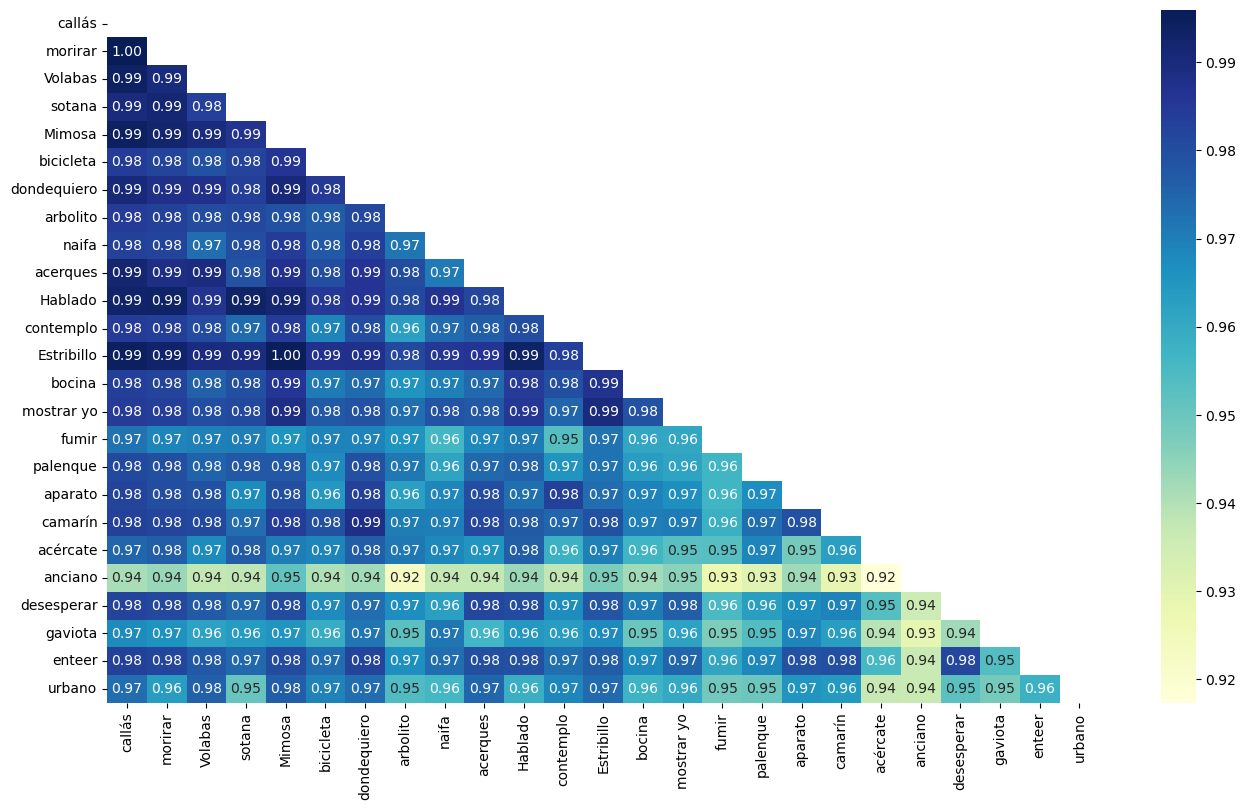

In [22]:
# Calcula la matriz de correlación para n términos más probables
# (se limita el tamaño a fines prácticos)
_ = embeddings_matrix_distance(w2v_model, sorted_words[:25])

Cantidad de palabras: 25
Dimensiones de los embeddings: (25, 300)


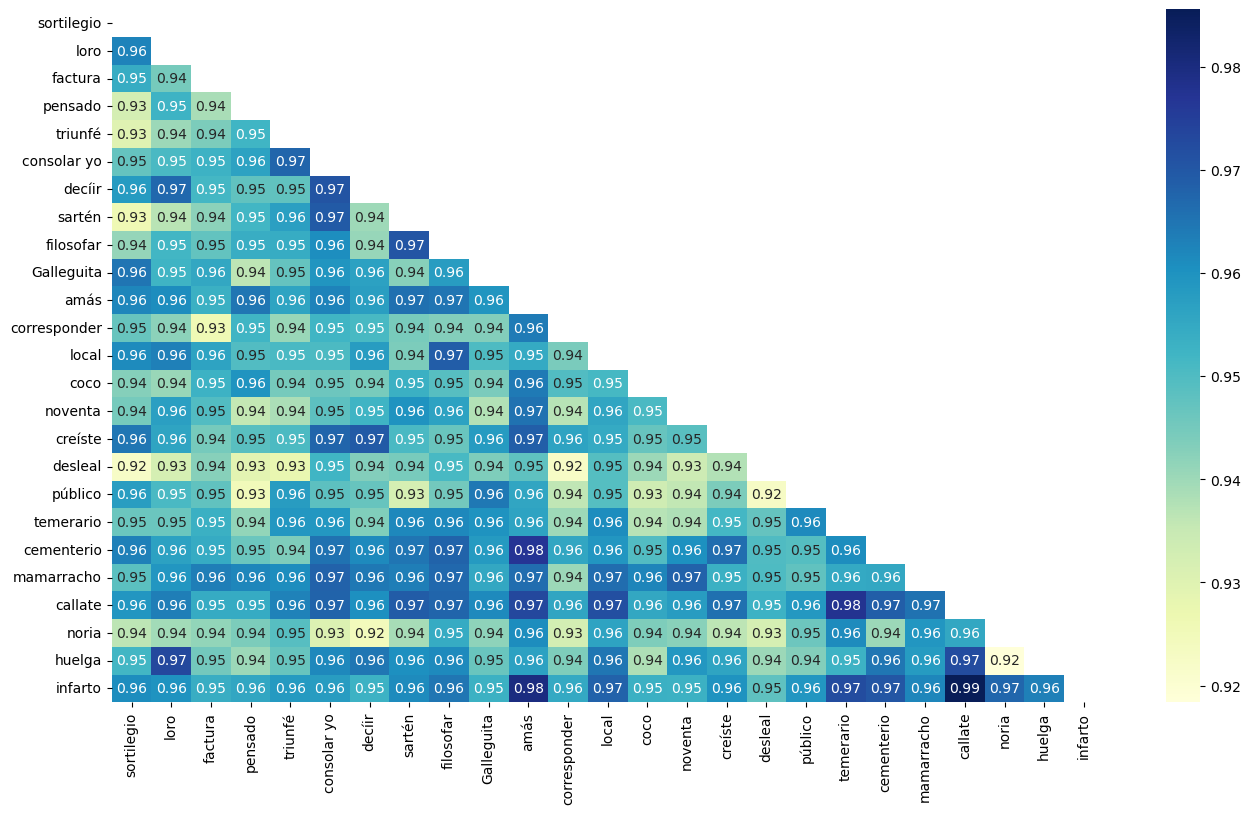

In [28]:
# Calcula la matriz de correlación para n términos más probables
# (se limita el tamaño a fines prácticos)
_ = embeddings_matrix_distance(w2v_model, sorted_words[25:50])

A modo de ejemplo, puede analizarse la correlación para algunos casos:
- *desleal*:
    - alta correlación con consolar yo, *filosofar*, *amás a*, *factura*,

Cantidad de palabras: 100
Dimensiones de los embeddings: (100, 300)


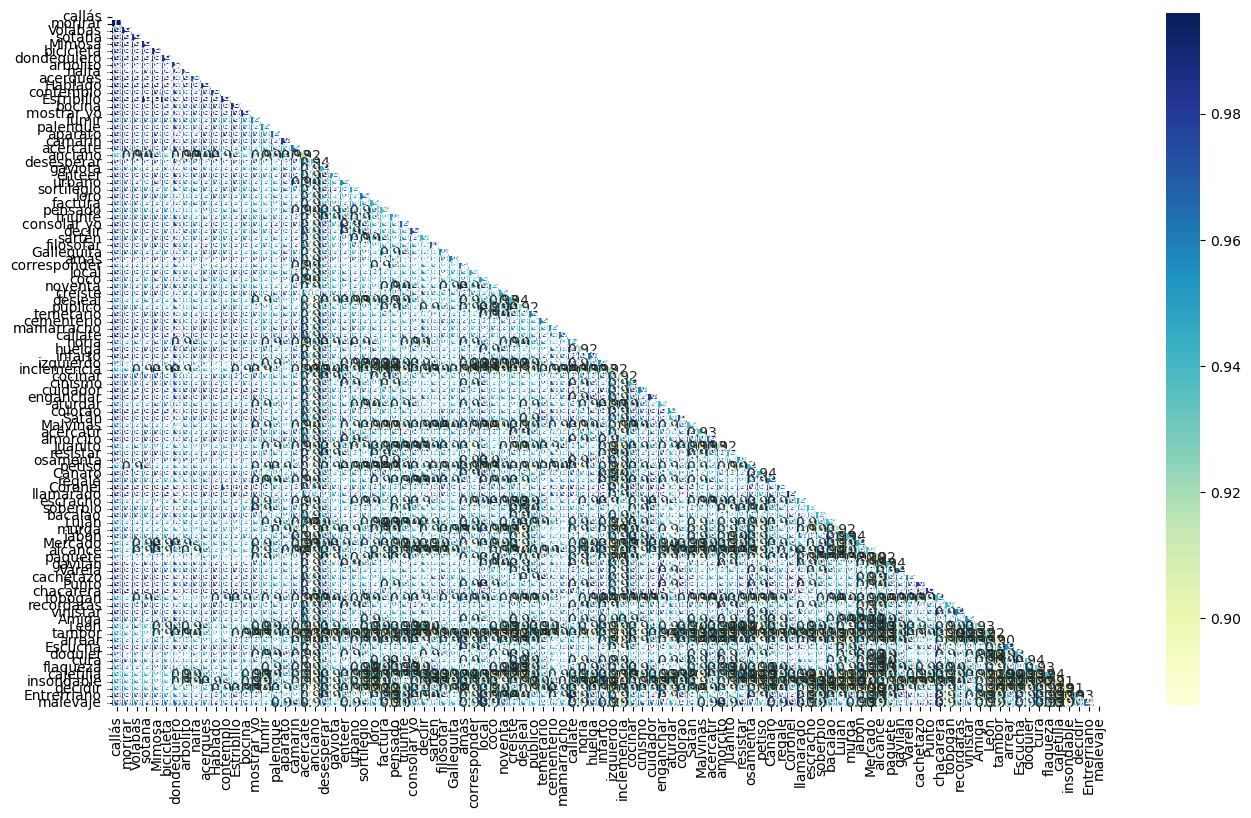

In [32]:
# Calcula la matriz de correlación para n términos más probables
# (se limita el tamaño a fines prácticos)
_ = embeddings_matrix_distance(w2v_model, sorted_words[:100])

### Las 100 palábras menos usadas

Cantidad de palabras: 25
Dimensiones de los embeddings: (25, 300)


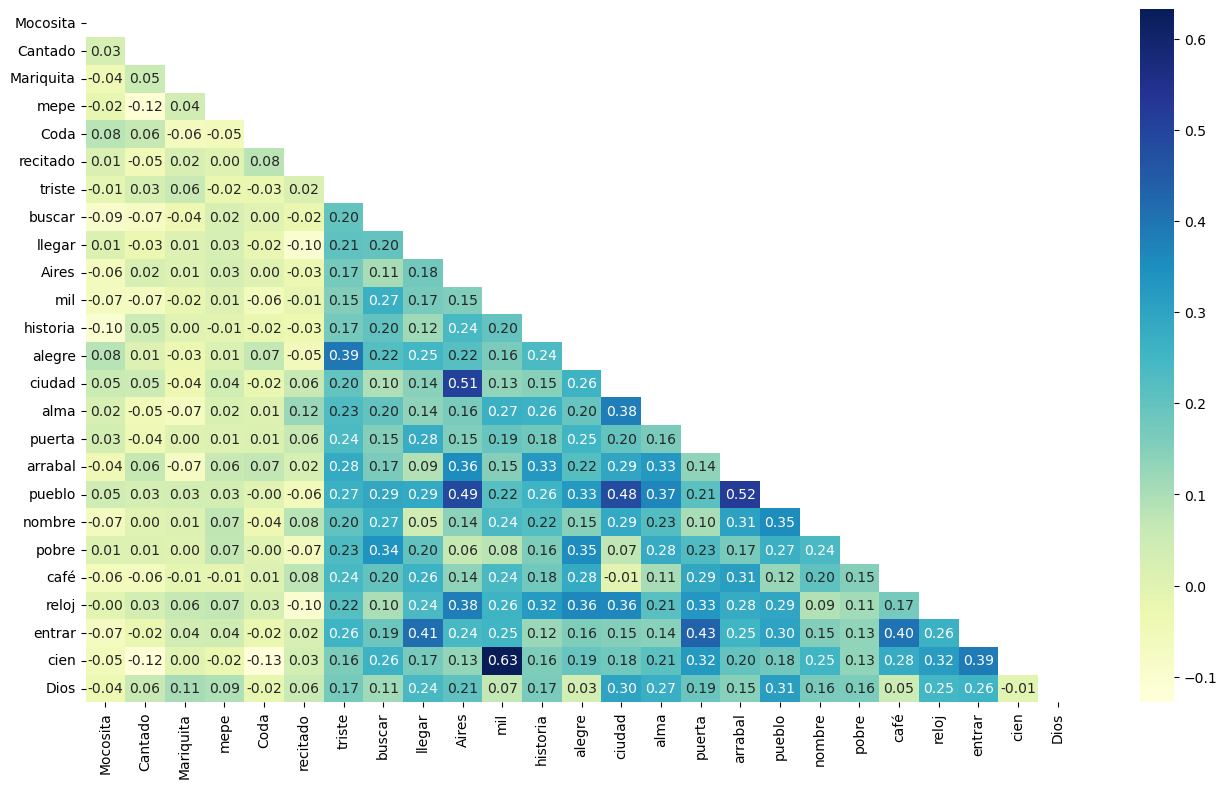

In [29]:
# Calcula la matriz de correlación para n términos más probables
# (se limita el tamaño a fines prácticos)
_ = embeddings_matrix_distance(w2v_model, uncommon_words[:25])

Cantidad de palabras: 25
Dimensiones de los embeddings: (25, 300)


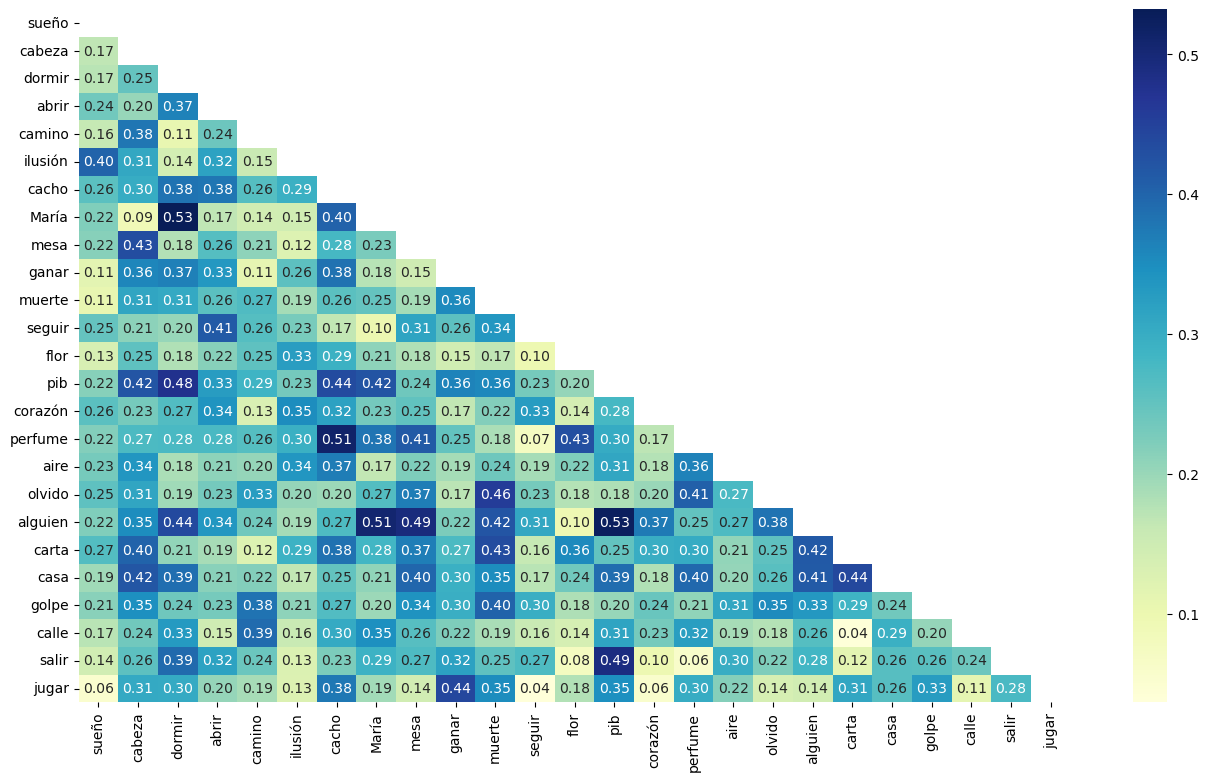

In [30]:
# Calcula la matriz de correlación para n términos más probables
# (se limita el tamaño a fines prácticos)
_ = embeddings_matrix_distance(w2v_model, uncommon_words[25:50])

In [ ]:
# probamos un test de analogía
test_words = ['king', 'man', 'woman', 'queen']
test_emb = model_fasttext.get_words_embeddings(test_words)

# king - man + woman
new_queen = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_queen']
new_emb = np.append(test_emb, new_queen.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

In [ ]:
# mas allá de las palabras propuestas, podemos ver cuál sería la palabra 
# cuyo embedding es más similar al de 'new_queen'
# para ello vamos a disponibilizar los embeddings como un numpy array
embeddings_fasttext = []
for idx,emb in enumerate(model_fasttext.embeddings):
  embeddings_fasttext.append(emb[1])
embeddings_fasttext = np.array(embeddings_fasttext)

In [ ]:
# calculamos la similaridad de 'new_queen' contra todos los vectores
# puede tardar unos segundos
similarities = np.squeeze(pairwise.cosine_similarity(embeddings_fasttext,np.array([new_queen])))

In [ ]:
# vemos cuáles son los 10 vectores más similares
args_sorted = np.argsort(similarities)[::-1][:10]
for arg in args_sorted:
  print(f'{words_fasttext[arg]}: {similarities[arg]}')

In [ ]:
test_words2 = ['anarchy', 'monarchy', 'kingdom', 'crown', 'royal']
test_emb2 = model_fasttext.get_words_embeddings(test_words2)

# king - man
no_king = test_emb[0] - test_emb[1]

new_words2 = test_words2 + ['no_king']
new_emb2 = np.append(test_emb2, no_king.reshape(1, -1), axis=0)

dist2 = pairwise.cosine_similarity(new_emb2, new_emb2)

plot_matrix_distance(new_words2, dist2)

In [ ]:
# king - royal
new_man = test_emb[0] - test_emb2[4]

new_words3 = test_words + ['new_man']
new_emb3 = np.append(test_emb, new_man.reshape(1, -1), axis=0)

dist3 = pairwise.cosine_similarity(new_emb3, new_emb3)

plot_matrix_distance(new_words3, dist3)

## 3. Test de analogías

### 3.1 Tests de analogías

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["mujer"], topn=10)

[('ilusionado', 0.5116168260574341),
 ('diste', 0.5043809413909912),
 ('canalla', 0.5022417902946472),
 ('manchar', 0.4949265420436859),
 ('cobardes', 0.49434614181518555),
 ('comprobé', 0.4828914701938629),
 ('canallo', 0.47851791977882385),
 ('sumiso', 0.47810572385787964),
 ('evocarte', 0.4760889708995819),
 ('Batime', 0.4758448302745819)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["amor"], topn=10)

[('Mariquita', 0.0779007077217102),
 ('Cantado', 0.07351255416870117),
 ('recitado', 0.06890612840652466),
 ('Mocosita', 0.01951618306338787),
 ('Coda', -0.023325808346271515),
 ('mepe', -0.028382759541273117),
 ('pinta', -0.05400623008608818),
 ('barrio', -0.08770376443862915),
 ('San', -0.09408677369356155),
 ('auto', -0.098653644323349)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["curda"], topn=10)

[('Saavedra', 0.8210236430168152),
 ('lío', 0.8067806363105774),
 ('chivo', 0.8059383034706116),
 ('lunfardo', 0.8005927205085754),
 ('quedatir', 0.7980812788009644),
 ('pese', 0.7951031923294067),
 ('rechifló', 0.7946130633354187),
 ('cuéntame', 0.7936882972717285),
 ('deliro', 0.7933650016784668),
 ('enamorada', 0.7897957563400269)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["guita"], topn=10)

[('tirón', 0.8591167330741882),
 ('bullón', 0.8507651090621948),
 ('usté', 0.8450626730918884),
 ('bacanazo', 0.8430323600769043),
 ('cola', 0.8214101195335388),
 ('morlaco', 0.8181175589561462),
 ('acordés', 0.8142064213752747),
 ('escasear', 0.8129075169563293),
 ('matecito', 0.8108312487602234),
 ('pasar él', 0.8103393316268921)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["yuta"], topn=10)

[('apoliyo', 0.9349864721298218),
 ('opinar', 0.9330763816833496),
 ('Caseros', 0.9307599067687988),
 ('saque', 0.9289268255233765),
 ('Saavedra', 0.9214191436767578),
 ('pila', 0.9122054576873779),
 ('esquinazo', 0.910224199295044),
 ('morlaco', 0.9089516401290894),
 ('quiniela', 0.9080372452735901),
 ('cachafaz', 0.9068960547447205)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["chorro"], topn=5)

[('mentao', 0.9078146815299988),
 ('chueco', 0.9053320288658142),
 ('galera', 0.9050260186195374),
 ('polaina', 0.9030206799507141),
 ('bibelot', 0.9029215574264526)]

In [ ]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["money"])

KeyError: "Key 'money' not present in vocabulary"

In [ ]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("mina")
print(vector_love)

[ 2.11395279e-01  1.84869543e-01 -4.03992161e-02  3.12222570e-01
 -4.31908756e-01 -3.30560565e-01  1.05894454e-01  3.38280499e-01
 -2.05962434e-01 -1.60029195e-02 -6.12791907e-03 -2.13558841e-02
  1.47789672e-01  1.87948197e-01 -3.92184585e-01  2.24639565e-01
  9.28881541e-02 -2.88488120e-01  2.44334452e-02 -2.20518053e-01
 -1.92322567e-01 -1.34722646e-02  2.88779587e-01 -1.67557836e-01
  1.45589203e-01  2.20279619e-01 -1.95605472e-01 -4.58489545e-02
 -3.84329259e-01  6.49476133e-04  1.78298548e-01 -1.05422571e-01
  1.89350009e-01 -7.27126077e-02 -2.58112341e-01 -4.18662935e-01
  2.70190328e-01 -2.01744467e-01  1.06728494e-01 -2.18386665e-01
 -5.60531914e-01 -6.40188977e-02 -4.31451239e-02 -1.02058992e-01
 -1.66311726e-01  3.88259351e-01 -3.57364938e-02  3.03461719e-02
  1.22163005e-01  3.24720830e-01 -4.13254388e-02  2.36895215e-02
  7.26208165e-02  2.29904473e-01 -2.73704559e-01  2.17536375e-01
 -1.90447763e-01  1.84611484e-01  3.58385406e-03 -5.47265038e-02
 -2.50456512e-01 -4.95642

In [ ]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)

[('mina', 1.0),
 ('otaria', 0.6640909910202026),
 ('inglés', 0.6521604657173157),
 ('funyi', 0.6499179005622864),
 ('gavión', 0.6441267728805542),
 ('diquera', 0.6383032202720642),
 ('retrechera', 0.6355450749397278),
 ('púa', 0.6349635720252991),
 ('cautivar', 0.6334444284439087),
 ('veterano', 0.6312074661254883)]

### 3.2 Grafico de embeddings

In [ ]:
#from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

## 4. Conclusiones